In [1]:
# in this script, different targets are predicted for comparing dense, CNN and lstm

import numpy as np
import pandas as pd
import molml 
from molml.features import CoulombMatrix, BagOfBonds
import sys
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, median_absolute_error
# sys.path.append("/home/peng/git/molml/")

# from molml_local.features import CoulombMatrix
# from molml_local.features import LocalCoulombMatrix
# from molml_local.kernel import AtomKernel

In [2]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, load_model

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)


In [ ]:
#flowchart for transfera learning
'''
1. Train a DNN for predicting target A
2. Use the trained weights as initial weight
3. Train it for predicting target B

'''

In [3]:
def get_attributes(element_list, coord_list):
    # produce [element, coord] lists for applying coulomb matrix and bob convertion

    fit_list = []

    for i in range(0, len(element_list)):
        fit_list.append((element_list[i], coord_list[i]))
        
    return fit_list 


def get_train_vali_test(train_list, target_list, test_szie=0.2, random_state = 32):
    
    train, test, trainlabel, testlabel = train_test_split(train_list, target_list,\
                                                      test_size=0.2, random_state = 32)

    train_, train_vali, train_label, vali_label = train_test_split(train, trainlabel, \
                                                              test_size=0.2, random_state = 32)
    
    return [train_, train_vali, test], [train_label, vali_label, testlabel]


In [4]:
def baseline_dnn():
    
    x = Input(shape=(666, ))
    h1 = Dense(666, activation = 'relu')(x)
    o1 = Dense(1, activation = 'linear', name='o1')(h1)
    o2 = Dense(1, activation = 'linear', name='o2')(h1)
    model = Model(inputs=[x], outputs=[o1, o2])
    
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    return model
    

In [5]:
def test_multi_dnn():

    x = Input(shape=(666, ))
    
    h1 = Dense(666, activation = 'relu')(x)
#    h1 = Dropout(0.1)(h1)
    h1 = Dense(666, activation = 'relu')(h1)
#    h1 = Dropout(0.1)(h1)
    h1 = Dense(666, activation = 'relu')(h1)
    
    o1 = Dense(1, activation = 'linear', name='o1')(h1)
    o2 = Dense(1, activation = 'linear', name='o2')(h1)
    o3 = Dense(1, activation = 'linear', name='o3')(h1)
    o4 = Dense(1, activation = 'linear', name='o4')(h1)
    o5 = Dense(1, activation = 'linear', name='o5')(h1)
    o6 = Dense(1, activation = 'linear', name='o6')(h1)
    
    model = Model(inputs=[x], outputs=[o1,o2,o3,o4,o5,o6])
    
  
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    return model

In [6]:
def test_single_dnn():

    x = Input(shape=(666, ))
    
    h1 = Dense(1000, activation = 'relu')(x)
#    h1 = Dropout(0.1)(h1)
    h1 = Dense(1000, activation = 'relu')(h1)
#    h1 = Dropout(0.1)(h1)
    h1 = Dense(1000, activation = 'relu')(h1)
    
    o1 = Dense(1, activation = 'linear', name='o1')(h1)
#     o2 = Dense(1, activation = 'linear', name='o2')(h1)
#     o3 = Dense(1, activation = 'linear', name='o3')(h1)
#     o5 = Dense(1, activation = 'linear', name='o4')(h1)
#     o5 = Dense(1, activation = 'linear', name='o5')(h1)
#     o6 = Dense(1, activation = 'linear', name='o6')(h1)
    
    model = Model(x, o1)
    
  
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    return model

In [9]:
def get_fit_targets(target_list = None):
    columns_list = target_list[0].columns
    train_targets = []
    vali_targets = []
    for i in columns_list:
        train_targets.append(np.array(target_list[0][i]))
        vali_targets.append(np.array(target_list[1][i]))
        
    return train_targets, vali_targets    

In [10]:
# 0. Some setting
other_list = ['A', 'B', 'C']

elec_list = ['dipole', 'polar','spatialSize', 'homo', 'lumo', 'gap']

thermo_list = ['U0', 'U', 'H', 'G', 'Cv','zpe']

metrics = [r2_score, mean_absolute_error, mean_squared_error, median_absolute_error]

results_list = []

In [11]:
# 1. data importing
data_path_pkl = '/home/peng/Documents/Project_C/QSAR_nlp/Dataset_qm9/'

df = pd.read_pickle(data_path_pkl + 'filter_133k.pkl')

print(df.columns)

Index([u'numAtoms', u'dbindex', u'A', u'B', u'C', u'dipole', u'polar', u'homo',
       u'lumo', u'gap', u'spatialSize', u'zpe', u'U0', u'U', u'H', u'G', u'Cv',
       u'atomList', u'atomCoords', u'freqs', u'SMILES', u'InChI'],
      dtype='object')


In [12]:
# 2. feature enigneering (BoB)
fit_list = get_attributes(np.array(df['atomList']), np.array(df['atomCoords']))
feature_methods = [CoulombMatrix(), BagOfBonds()]
feat_co = feature_methods[1]
train_list = feat_co.fit_transform(fit_list)
train_list_scale = MinMaxScaler().fit_transform(train_list)

In [13]:
def train_DNN(target_single=None, model_old = None, epochs = 100):
    
    #Run1, the single-DNN on electro_list:
    start = timeit.default_timer()

    #R1 generate feature and target_list:
    feature_list, target_list = get_train_vali_test(train_list_scale, df[target_single])

    #R3 instance model and fit
    if model_old:
        model_1 = model_old
        
    else:
        model_1 = test_single_dnn()

    history = model_1.fit(feature_list[0], target_list[0],\
                                    shuffle=True,
                nb_epoch=epochs,
                batch_size=100,
                verbose = 0,
               validation_data = (feature_list[1], \
                                   target_list[1]))

    stop = timeit.default_timer()

    print ("The running takes %r min" %((stop-start)/60))
    
    return model_1, history, feature_list, target_list


def plot_loss(history = None):
    # plot the loss 
    print(history.history.keys())
    #plt.plot(history.history['o2_loss'])
    #plt.plot(history.history['val_o2_loss'])
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.legend()
    plt.show()
    
    
def metric_check(model_=None, feature_list=None, target_list=None):
    # predict results and check the predicting performance 
    pred_target_1 = np.reshape(model_.predict(feature_list[-1]),-1)
    for metric in metrics:
        print (str(metric), metric(pred_target_1, target_list[-1]))

In [74]:
# RR1, check target_3
model_3, history_3, feature_list_3, target_list_3 = train_DNN(elec_list[-3])
plot_loss(history = history_3)
metric_check(model_3, feature_list_3, target_list_3 )

The running takes 2.932003668944041 min


The running takes 4.878322664896647 min
['loss', 'val_loss']


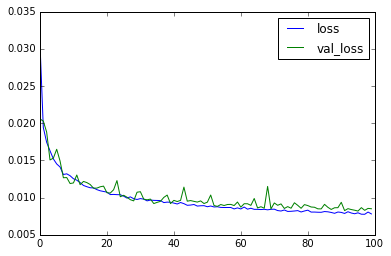

('<function r2_score at 0x7f8eb98ee320>', 0.92779444803455235)
('<function mean_absolute_error at 0x7f8eb98ee140>', 0.0085167677260552348)
('<function mean_squared_error at 0x7f8eb98ee1b8>', 0.00014901878400228134)
('<function median_absolute_error at 0x7f8eb98ee230>', 0.0059687693059444422)


In [14]:
# this is the real start
model_2, history_2, feature_list_2, target_list_2 = train_DNN(elec_list[-2])
plot_loss(history = history_2)
metric_check(model_2, feature_list_2, target_list_2 )

The running takes 4.805911699930827 min
['loss', 'val_loss']


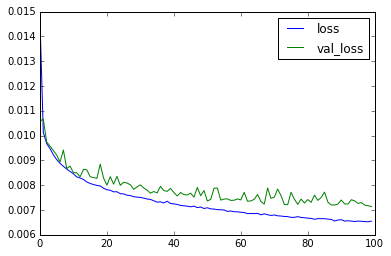

('<function r2_score at 0x7f8eb98ee320>', 0.7878862890115359)
('<function mean_absolute_error at 0x7f8eb98ee140>', 0.0070875666901958397)
('<function mean_squared_error at 0x7f8eb98ee1b8>', 9.1289002356328565e-05)
('<function median_absolute_error at 0x7f8eb98ee230>', 0.0054807828903198352)


In [15]:
model_3f2, history_3f2, feature_list_3f2, target_list_3f2 = train_DNN(elec_list[-3], model_2)
plot_loss(history = history_3f2)
metric_check(model_3f2, feature_list_3f2, target_list_3f2 )

The running takes 9.705379033088684 min
['loss', 'val_loss']


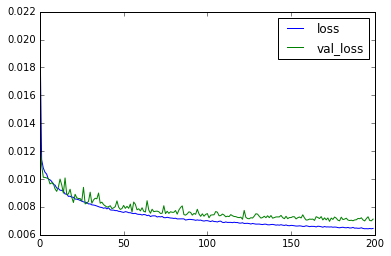

('<function r2_score at 0x7f8eb98ee320>', 0.78632750862345913)
('<function mean_absolute_error at 0x7f8eb98ee140>', 0.0071188772074962216)
('<function mean_squared_error at 0x7f8eb98ee1b8>', 9.0467310846818269e-05)
('<function median_absolute_error at 0x7f8eb98ee230>', 0.005601293420791631)


In [16]:
model_3300, history_3300, feature_list_3300, target_list_3300 = train_DNN(target_single=elec_list[-3], epochs=200,\
                                                                  model_old = None)
plot_loss(history = history_3300)
metric_check(model_3300, feature_list_3300, target_list_3300 )

In [143]:
'''
#Run1, the multi-DNN on electro_list:
start = timeit.default_timer()

#R1 generate feature and target_list:
feature_list, target_list = get_train_vali_test(train_list_scale, df[elec_list])

#R2 generate train, vali, and test target lists for convienient usage for fitting
train_targets, vali_targets = get_fit_targets(target_list=target_list)

#R3 instance model and fit

model_1 = test_multi_dnn()

history = model_1.fit(feature_list[0], train_targets,\
                                shuffle=True,
            epochs=100,
            batch_size=100,
            verbose = 0,
           validation_data = (feature_list[1], \
                              vali_targets))

stop = timeit.default_timer()

print ("The running takes %r min" %((stop-start)/60))

'''

The running takes 4.644140148162842 min


In [146]:
# R4 save the model
model_1.save('Results/model_multi_dnn_elec.h5')

In [147]:
#R5 predict the test set
test_results = model_1.predict(feature_list[-1])
test_results_dic = {}
for i in xrange(0, np.shape(test_results)[0]):
    test_name = '0'+str(int(i+1))
    test_results_dic[test_name] = np.reshape(test_results[i], -1)

In [160]:
#R6 store history and predicted_test_results
df_test_results=pd.DataFrame(test_results_dic)
df_test_results.to_csv('Results/predict_test_multiDNN_elec.csv', header =True )
df_history = pd.DataFrame(history.history)
df_history.to_csv('Results/history_multiDNN_elec.csv', header=True)

In [121]:
# 2.5 generate feature list and target list 
feature_list, target_list = get_train_vali_test(train_list_scale, df[['gap', 'homo']])

In [99]:
model_1 = test_dnn()

history = model_1.fit(feature_list[0], [np.array(target_list[0]['gap']), np.array(target_list[0]['homo'])],\
                                shuffle=True,
            epochs=20,
            batch_size=100,
            verbose = 0,
           validation_data = (feature_list[1], \
                              [np.array(target_list[1]['gap']), np.array(target_list[1]['homo'])]))

In [197]:
df[elec_list].describe()

,dipole,polar,spatialSize,homo,lumo,gap
count,130831.000000,130831.000000,130831.000000,130831.000000,130831.000000,130831.000000
mean,2.672953,75.281185,1189.410643,-0.240210,0.011835,0.252045
std,1.503479,8.173831,280.478157,0.021967,0.046850,0.047192
min,0.000000,6.310000,19.000200,-0.428600,-0.175000,0.024600
25%,1.577800,70.480000,1017.431250,-0.252600,-0.023300,0.217000
50%,2.475300,75.600000,1147.221100,-0.241100,0.012600,0.250200
75%,3.596350,80.610000,1309.047000,-0.228900,0.050900,0.289400
max,29.556400,196.620000,3374.753200,-0.101700,0.193500,0.622100
